In [1]:
import os
import sys
import struct
import pprint
import matplotlib.pyplot as plt
import pickle
import math
import time
import statistics
import numpy as np
%pylab inline

from TraceInc import AutoDict
pp = pprint.PrettyPrinter(indent=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ctaMap(tmap):
    ctaSet = {}
    xmask = 0xFFFFFF00000000 
    ymask = 0x000000FFFF0000
    zmask = 0x0000000000FFFF
    ctaSet["x"] = set()
    ctaSet["y"] = set()
    ctaSet["z"] = set()
    for sk in tmap:
        for cta in tmap[sk]:
            ctaSet["x"].add((cta & xmask) >> 32)
            ctaSet["y"].add((cta & ymask) >> 16)
            ctaSet["z"].add((cta & zmask))
            for sit in tmap[sk][cta]:
                for rk in tmap[sk][cta][sit]:
                    for rcta in tmap[sk][cta][sit][rk]:
                        ctaSet["x"].add((rcta & xmask) >> 32)
                        ctaSet["y"].add((rcta & ymask) >> 16)
                        ctaSet["z"].add((rcta & zmask))
    return ctaSet

In [3]:
def bisectionVolume(tmap,ctaSet,cuts):
    xmask = 0xFFFFFF00000000 
    ymask = 0x000000FFFF0000
    zmask = 0x0000000000FFFF
    catSet = AutoDict()
    bw = AutoDict()
    bw["x"] = 0
    bw["y"] = 0
    bw["z"] = 0
    xcut = len(ctaSet["x"])/2
    ycut = len(ctaSet["y"])/2
    zcut = len(ctaSet["z"])/2
    total=0

    for sk in tmap:
        for cta in tmap[sk]:
            sx = (cta & xmask) >> 32
            sy = (cta & ymask) >> 16
            sz = (cta & zmask)
            for sit in tmap[sk][cta]:
                for rk in tmap[sk][cta][sit]:
                   for rcta in sorted(tmap[sk][cta][sit][rk]):
                       for rit in tmap[sk][cta][sit][rk][rcta]:
                            #if not bw["x"][sit][rit]:
                            #    bw["x"][sit][rit] = 0
                            #if not bw["y"][sit][rit]:
                            #    bw["y"][sit][rit] = 0
                            #if not bw["z"][sit][rit]:
                            #    bw["z"][sit][rit] = 0
                            rx = (rcta & xmask) >> 32
                            ry = (rcta & ymask) >> 16
                            rz = (rcta & zmask)
                            total += tmap[sk][cta][sit][rk][rcta][rit]['size']
                            if (sx < xcut): 
                                if (sx - rx < 0): # 0 -> 2 transition
                                    #bw["x"][sit][rit] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                                    bw["x"] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                            else:
                                if (rx < xcut):
                                    #bw["x"][sit][rit] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                                    bw["x"] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                            if (sy < ycut): 
                                if (sy - ry < 0): # 0 -> 2 transition
                                    #bw["y"][sit][rit] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                                    bw["y"] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                            else:
                                if (ry < ycut):
                                    #bw["y"][sit][rit] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                                    bw["y"] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                            if (sz < zcut): 
                                if (sz - rz < 0): # 0 -> 2 transition
                                    #bw["z"][sit][rit] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                                    bw["z"] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                            else:
                                if (rz < zcut):
                                    #bw["z"][sit][rit] += tmap[sk][cta][sit][rk][rcta][rit]['size']
                                    bw["z"] += tmap[sk][cta][sit][rk][rcta][rit]['size']

    return (bw, total)

In [4]:
def writeVol(kmap):
    pp.pprint(kmap['KCV'])
    total = 0
    for k in kmap['KCV']:
        for it in kmap['KCV'][k]:
            total += kmap['KCV'][k][it]['Store'] or 0 + kmap['KCV'][k][it]['Load']
    return total

In [5]:
files = ['hs2d', 'hs3d','hist', 'nbody', 'path', 'bfs']
fpath = '../data/'

In [6]:
xvols = []
yvols = []
zvols = []
xrate = []
yrate = []
for f in files:
    file = fpath + f + '.transfermap'
    tmap = pickle.load( open(file, "rb"))
    ctaSet = ctaMap(tmap)
    biVol,tv = bisectionVolume(tmap, ctaSet,2)
    xrate.append((biVol["x"])/tv*100)
    yrate.append((biVol["y"])/tv*100)
    xvols.append(biVol["x"])
    yvols.append(biVol["y"])
    zvols.append(biVol["z"])


In [7]:
pp.pprint(xvols)
pp.pprint(yvols)
pp.pprint(zvols)
pp.pprint(xrate)
pp.pprint(yrate)

[500480, 737280, 567424, 479232, 58512, 3339715]
[500480, 9584640, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[ 15.620006391818473,
  1.8656716417910446,
  50.720823798627,
  56.52173913043478,
  9.33479681437615,
  44.34789617669922]
[15.620006391818473, 24.253731343283583, 0.0, 0.0, 0.0, 0.0]


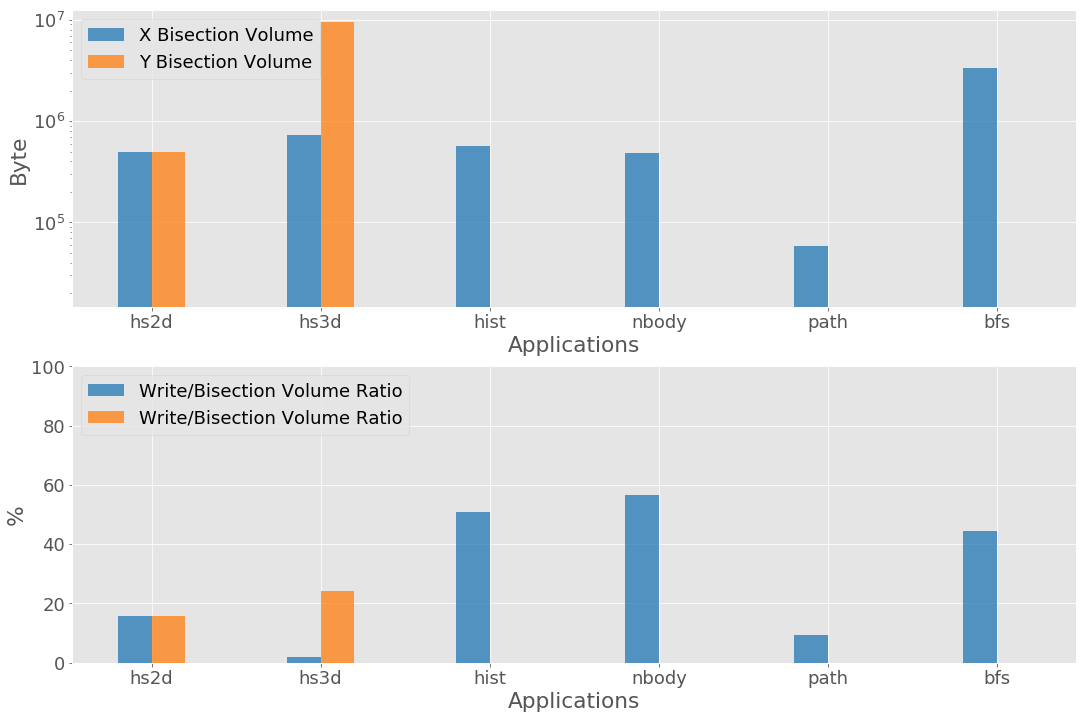

In [8]:
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (18, 12)
matplotlib.rcParams.update({'font.size': 18})
cmap = matplotlib.cm.get_cmap('tab10')
c = cmap.colors

ind = np.arange(len(files))
bottom = np.zeros(len(files))
plt.subplot(211)
width = 0.2
plt.bar(ind-width/2, xvols, width=width, alpha=0.75, bottom=bottom, label='X Bisection Volume', color=c[0])
plt.bar(ind+width/2, yvols, alpha=0.75,width=width, bottom=bottom, label='Y Bisection Volume', color=c[1])
#plt.bar(ind, zvols, alpha=0.75,width=width, bottom=bottom, label='Z Bisection Volume', color=c[2])


plt.ylabel('Byte')
plt.xlabel('Applications')
plt.yscale('log')
plt.ylim(ymin=min(xvols)/4)
plt.xticks(ind, files)
plt.legend(loc=2)
width = 0.2 

plt.subplot(212)
plt.bar(ind-width/2, xrate, width=width, alpha=0.75, label='Write/Bisection Volume Ratio', color=c[0])
plt.bar(ind+width/2, yrate, width=width, alpha=0.75, label='Write/Bisection Volume Ratio', color=c[1])


plt.ylabel('%')
plt.xlabel('Applications')
plt.ylim([0,100])
plt.xticks(ind, files)
plt.legend(loc=2)

filename = '../plots/bisection-volume.pdf'
plt.savefig(filename, papertype='a4', bbox_inches='tight', orientation='landscape')
plt.show()